In [1]:
import json
from bedrock_text import BedrockText
from bedrock_image import BedrockAmazonImage, NovaImageSize, ImageParams, ControlMode
from bedrock_model import BedrockModel
from image_utils import (
    get_image_bytes_from_file,
    bytes_to_base64,
    display_image,
    display_image_bytes,
)

## 0. Declare required models, classes, variables, and data

In [7]:
AWS_REGION = "us-east-1"

SAMPLE_IMAGE_PATH = "./sample/food.jpg"
SAMPLE_IMAGE_FORMAT = "jpeg"

In [8]:
# LLM model
bedrock_llm = BedrockText(modelId=BedrockModel.NOVA_LITE_CR, region=AWS_REGION)

# Image model
bedrock_image = BedrockAmazonImage(region=AWS_REGION, modelId=BedrockModel.NOVA_CANVAS)

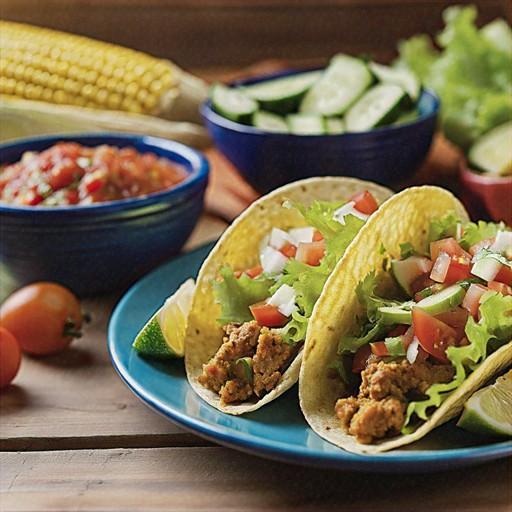

In [9]:
# sample image
img_bytes = get_image_bytes_from_file(file_path=SAMPLE_IMAGE_PATH, format=SAMPLE_IMAGE_FORMAT)
display_image_bytes(img_bytes)

# (Optional) if you have any information about the image, fill in this field.
photo_text = ""

## 1. Image-to-Text (Nova Lite)

In [10]:
PROMPT = f"""You are a copywriter who looks at an image and creates ideas to expand that image.
Refer to the given image and image description to write both the menu name and an image description in one sentence in English.

## Image Description

{photo_text}

## Output Format

Please provide your description in the following format, without any additional explanation:
{{
    "menu_name": "Name of the dish based on the image",
    "prompt": "A one-sentence visual description of the food items included in the image"
}}
"""

res = bedrock_llm.converse_output(text=PROMPT, image=img_bytes, format=SAMPLE_IMAGE_FORMAT)
j = json.loads(res)
menu_name = j.get('menu_name', '')
prompt = j.get('prompt', '')

print(menu_name)
print(prompt)

Turkey Tacos with Fresh Toppings
Two turkey tacos filled with seasoned turkey, lettuce, tomatoes, and cucumbers, served on a blue plate with salsa, lime wedges, and corn on the cob in the background.


## 2. Text-to-Image (Nova Canvas)


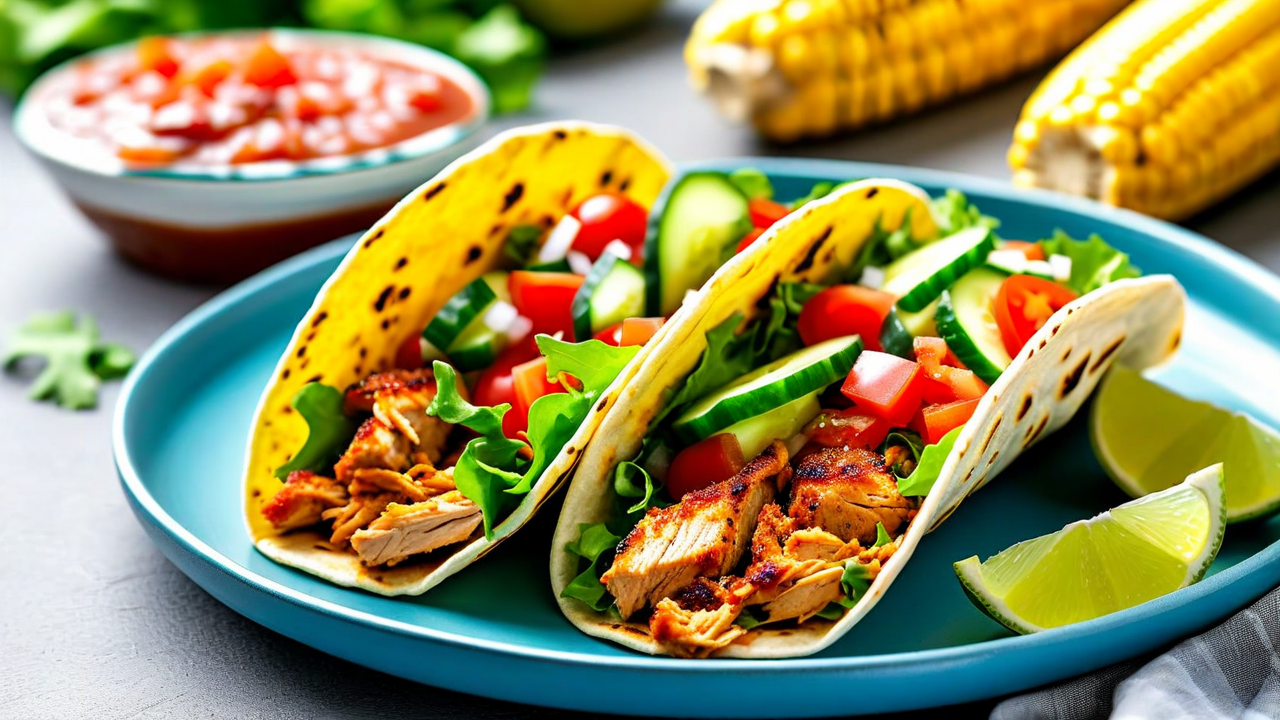

In [11]:
width, height = NovaImageSize.SIZE_1280x720.value
image_params = ImageParams(
    count=1,
    width=width,
    height=height,
    cfg=8.0,
)

body = image_params.text_to_image(text=prompt)
img = bedrock_image.generate_image(body)
display_image(img)

## 3. Image-to-Image (Nova Canvas)


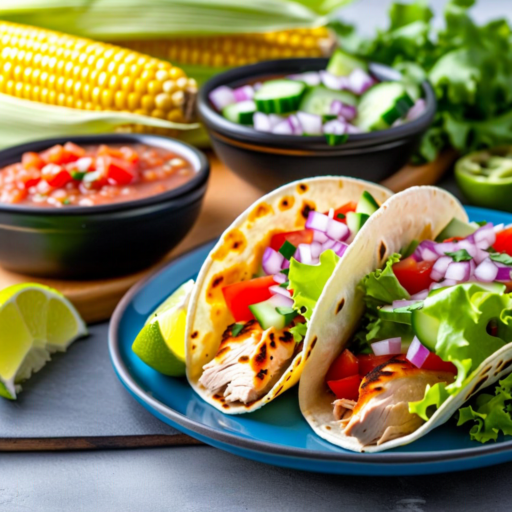

In [12]:
width, height = NovaImageSize.SIZE_512x512.value
image_params = ImageParams(
    count=1,
    width=width,
    height=height,
    cfg=8.0,
)

body = image_params.text_to_image(
    text=prompt,
    condition_image=bytes_to_base64(img_bytes),
    control_mode=ControlMode.CANNY_EDGE,
    control_strength=0.7,
)
img = bedrock_image.generate_image(body)
display_image(img)

## 4. Generate image prompts to create new content (Nova Lite)

In [13]:
PROMPT = f"""You are a culinary expert and a creative image prompt generator.

## Food

{menu_name}

## Instruction

1. Analyze the provided dish name and image to understand the appearance and characteristics of the food.
2. Describe how to prepare the dish in four sequential steps, ensuring the final result resembles the provided image:
 - Harvesting the main ingredients
 - Preparing the ingredients
 - Cooking process
 - Plating the dish
3. For each step, write a clear and detailed prompt for image generation.
4. Maintain a consistent style across all prompts.

## Output format

Please provide your description in the following format, without any additional explanation:
[
    "prompt1",
    "prompt2",
    "prompt3",
    "prompt4"
]
"""

res = bedrock_llm.converse_output(text=PROMPT)
prompts = json.loads(res)
print(prompts)

['A close-up of fresh turkey meat, finely chopped and ready for tacos, with a rustic wooden chopping board in the background.', "A close-up of a chef's hands seasoning finely chopped turkey meat with spices, on a wooden chopping board, with a bowl of spices and a knife nearby.", 'A close-up of a skillet with turkey meat being cooked, showing the meat browning and sizzling, with steam rising from the pan.', 'A beautifully plated dish of turkey tacos with fresh toppings, including lettuce, tomatoes, and cheese, on a white plate with a rustic wooden background.']


## 5. Generate new image contents (Nova Canvas)

A close-up of fresh turkey meat, finely chopped and ready for tacos, with a rustic wooden chopping board in the background.



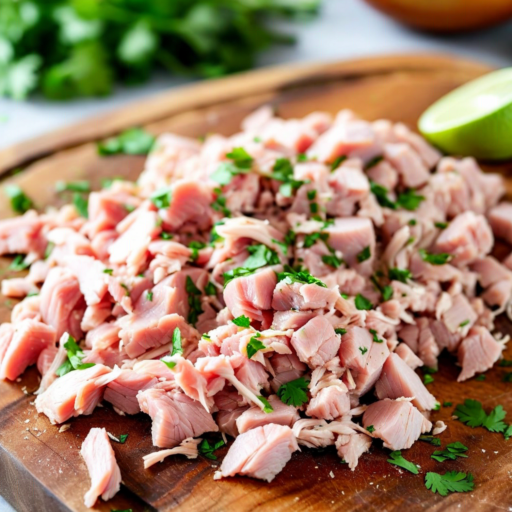

A close-up of a chef's hands seasoning finely chopped turkey meat with spices, on a wooden chopping board, with a bowl of spices and a knife nearby.



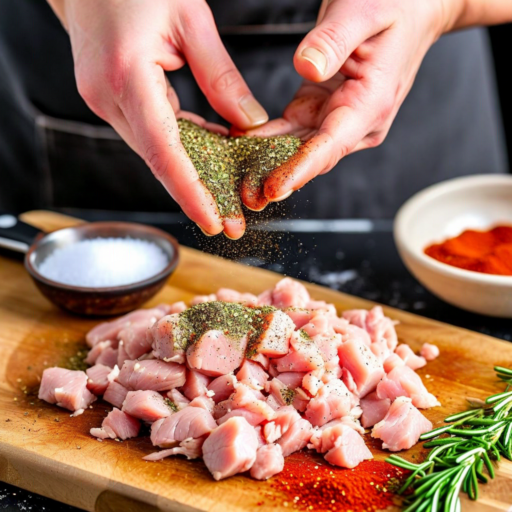

A close-up of a skillet with turkey meat being cooked, showing the meat browning and sizzling, with steam rising from the pan.



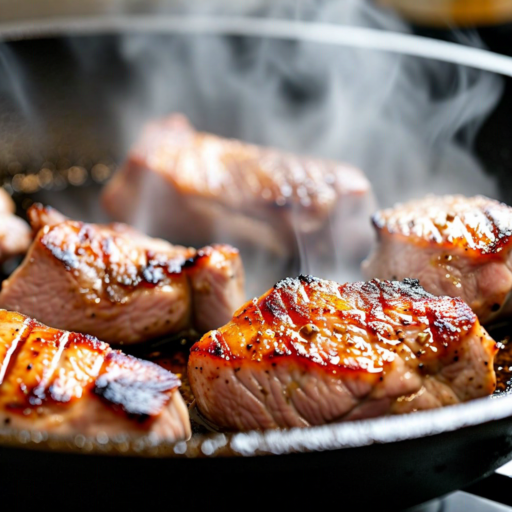

A beautifully plated dish of turkey tacos with fresh toppings, including lettuce, tomatoes, and cheese, on a white plate with a rustic wooden background.



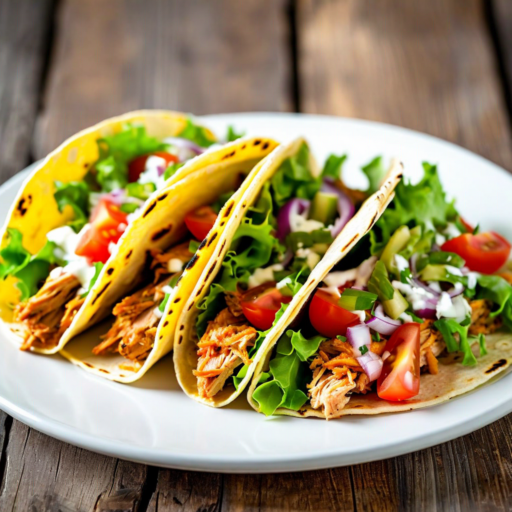

In [14]:
width, height = NovaImageSize.SIZE_512x512.value
image_params = ImageParams(
    count=1,
    width=width,
    height=height,
    cfg=8.0,
)

for prompt in prompts:
    print(prompt)
    body = image_params.text_to_image(text=prompt)
    img = bedrock_image.generate_image(body)
    display_image(img)